<a href="https://colab.research.google.com/github/DaanKuyper/DocumentSplitting/blob/master/Hugging_Face_Models_for_retrieval_of_Implicit_Feedback.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Retrieval of Implicit Feedback via Hugging Face models
### 1. Set up
- Import required packages.
- Load input data and inspect it.

### 2. Preprocessing
- Removal of any unnecessary content from input.

### 3. De-identification
 - Identifying and subsequent removal of potential sensitive information from the input for privacy reasons.

### 4. Language detection
- Detection of language for optimal result gerenation later on.

### 5. Insight generation
- The running of multiple different NLP tasks in order to depict valuable insights.

### 6. Visualisation
- Using the output from the NLP models to depict them in more imidiately insightful ways.

In [ ]:
!nvidia-smi

Fri Aug 26 07:25:58 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   45C    P8     9W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# Imports

In [1]:
%%capture
!pip install transformers
!pip install pytorch-lightning
# !pip install sentencepiece

In [2]:
import os
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from google.colab import drive
from transformers import pipeline, AutoTokenizer, AutoModelForSequenceClassification
from torch.utils.data import Dataset

In [3]:
# Mount google drive for easy access to input csv file.
drive.mount('/content/drive', force_remount=False)

# The textual input for the following generating of results, a csv file is used. 
# However, any method of creating a pandas DataFrame for the context is valid.
train_path, delimiter = '/content/drive/MyDrive/Scriptie/data.csv', ';'

dataframe = pd.read_csv(train_path, delimiter=delimiter)
comments = dataframe.comment

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Interaction

In [66]:
class ModelInfo():
  """
  Args:
      name (`str`): name of pre-trained model.
      task (`str`): name of pipeline task.
      language (`str`, *optional*): specific language for the model.
  """

  def __init__(self, task, name, language='all'):
    self.task = task
    self.name = name
    self.language = language

  def toString(self):
    return f"{self.task} on '{self.name}' for '{self.language}' language"



class Insight_Generator():
  """
  Args:
      input (`List[str]`): List of input texts.
      languageModel (`str`, *optional*): Model used for language detection.
  """

  def __init__(
      self,
      input,
      languageModel='papluca/xlm-roberta-base-language-detection'
  ):
    self.input = self.preprocess(input)
    self.languageModel = languageModel

    # Subsets of input per specific language
    self.language_subsets = {}

    # Dictionary of model insight results
    self.insights = {}

    # Truncation on: for comments longer than 512 token sequence...
    self.tokenizer_kwargs = {'truncation':True}

  
  def preprocess(self, input):
    #  - Removing NaN values
    df = pd.DataFrame(input)
    df.fillna('', inplace=True)

    # - Removal of \n
    safe_comments = [comment.replace('\n', ' ') for comment in df.comment]

    return safe_comments


  def detectLanguages(self):
    ld_df = self.generateInsight("text-classification", self.languageModel)

    print(f"Detected languages: {np.unique(ld_df.label)}")

    # Link original comment back to language detection results
    ld_df['comment'] = self.input

    # Split dataset in sets of detected language
    for language in ld_df.label:
      self.language_subsets[language] = \
        ld_df.comment.take(np.where(ld_df.label == language)[0]).tolist()

    # Set result as class property to allow for later inspection
    self.ld_df = ld_df


  def generateInsight(self, task, model, language="all"):
    # Device=0 to utilize GPU
    classifier = pipeline(task, model=model, device=0)

    input = self.languageSpecificInput(language)
    dataframe = pd.DataFrame(classifier(input, **self.tokenizer_kwargs))

    print(f"Average score of {dataframe.score.mean()} - for {task} on model '{model}'")

    return dataframe


  def generateInsights(self, models):
    for model in models:
      self.insights[model.toString()] = \
        self.generateInsight(model.task, model.name, model.language)


  def languageSpecificInput(self, language):
    return self.input if language == "all" else self.commentsByLanguage(language).comment
  

  def commentsByLanguage(self, language):
    return self.commentsByLanguages([language])


  def commentsByLanguages(self, languages):
    return self.ld_df.loc[self.ld_df.label.isin(languages)]


In [67]:
generator = Insight_Generator(comments)

In [68]:
%%time
generator.detectLanguages()

Average score of 0.9811817382880044 - for text-classification on model 'papluca/xlm-roberta-base-language-detection'
Detected languages: ['en' 'hi' 'nl' 'pt' 'sw' 'th' 'tr' 'ur']
CPU times: user 22.3 s, sys: 1.39 s, total: 23.7 s
Wall time: 30.8 s


In [69]:
# The following can be used to view accuracy score for specific languages
generator.commentsByLanguage('hi').score.mean()

0.4651397267977397

In [70]:
%%time
generator.generateInsights([
    ModelInfo("sentiment-analysis", "nlptown/bert-base-multilingual-uncased-sentiment")
])

Average score of 0.41914080187431596 - for sentiment-analysis on model 'nlptown/bert-base-multilingual-uncased-sentiment'
CPU times: user 19.1 s, sys: 549 ms, total: 19.6 s
Wall time: 24.2 s


In [60]:
generator.insights

{"sentiment-analysis on 'nlptown/bert-base-multilingual-uncased-sentiment' for all":         label     score
 0     3 stars  0.366226
 1     5 stars  0.327739
 2      1 star  0.515225
 3      1 star  0.469728
 4     2 stars  0.332995
 ...       ...       ...
 1384  3 stars  0.564639
 1385   1 star  0.435185
 1386  5 stars  0.372388
 1387   1 star  0.295357
 1388   1 star  0.510464
 
 [1389 rows x 2 columns]}

## Visualization

In [61]:
def LabelPiePlot(dataframe):
  labels = np.unique(dataframe.label)
  ld_gg = dataframe.groupby(by=dataframe.label)

  means = []
  for label in labels:
      means.append(len(ld_gg.groups[label]) / len(dataframe))

  fig, ax = plt.subplots()
  ax.pie(means, labels=labels, autopct='%1.1f%%', startangle=90)
  plt.show()

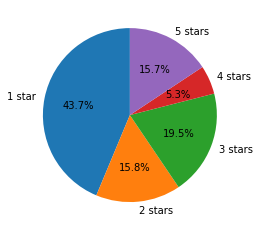

In [65]:
LabelPiePlot(generator.insights["sentiment-analysis on 'nlptown/bert-base-multilingual-uncased-sentiment' for all"])